In [8]:
import os
import boto3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sagemaker.session import Session

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AffinityPropagation, KMeans, AgglomerativeClustering

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

## Helper Functions & Classes

In [11]:
# small class for holding "special" print flags
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Interact with System Environment

In [12]:
# initiate s3 bucket and corresponding data folder
bucket = "ran-s3-systemic-risk"
data_folder ="Output/BalanceSheet/"

# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# discover all of the pdfs that you want to parse
paths = np.array(session.list_s3_files(bucket, data_folder))

## Line Item Label Clustering
**Using KMeans clustering for determing word similitaries amongst balance sheet items**

In [13]:
def word_matching(array: np.array, vectorizer_class, cluster_class) -> tuple:
    
    # Convert a collection of text documents to a matrix of token counts
    vectorizer = vectorizer_class
    print('Using the {} text vectorizer\n'.format(type(vectorizer_class).__name__))
    
    # produces a sparse representation of the counts using scipy.sparse.csr_matrix.
    X = vectorizer.fit_transform(array)
    
    # initialize the clustering model on words
    model = cluster_class
    
    model.fit(X)  # fit clustering model to array of strings

    # returns dataframe, mapping cluster labels to line items
    outDF = pd.DataFrame({'Labels': model.labels_, 'LineItems': array})
    
    print('\n{} clusters were found using {} algorithm'.format(model.labels_.max()+1, type(cluster_class).__name__))
    
    return model.labels_, model.cluster_centers_, outDF 

In [14]:
# reading cleaned unstructured data sets for samples 
# read in asset and liability line items to be parsed
s3.download_file(bucket, 'Output/unstructured_assets.csv', 'temp.csv')
assets = pd.read_csv('temp.csv')
s3.download_file(bucket, 'Output/unstructured_liable.csv', 'temp.csv')
liability = pd.read_csv('temp.csv')

os.remove('temp.csv')

**The following clustering model specifications are outlined below:**

- **array:** We select the columns from either asset or liability tables, not including CIK or Year components.
- **vectorizer_class:** We implement a standard TfidVectorizer class, converting the collection of strings to a matrix of TF-IDF features.

- **cluster_class:** We fit a KMeans clustering algorithm, employing **35 cluster** using the the classic **expectation–maximization algorithm (full)** for computing the KMeans clusters with **25 centroid seeds** to check against. We also control the random state and provided verbosity to model fits

In [15]:
clusters = 35
text_vectorizer = TfidfVectorizer(lowercase=True)
cluster_mdl = KMeans(n_clusters=clusters, n_init=25, verbose=1, random_state=1, algorithm='full')

In [16]:
# perform clustering on the asset line items
assetTerms = assets.columns.values[2:]
np.random.shuffle(assetTerms)

# divide asset terms into in and out of sample categories
insAssets = assetTerms[:-50]
outAssets = assetTerms[-50:]
assetlabel, assetCenters, df1 = word_matching(array = insAssets, 
                                              vectorizer_class = text_vectorizer, 
                                              cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration 0, inertia 1452.984106425532.
Iteration 1, inertia 904.2121208628088.
Iteration 2, inertia 891.1897844771338.
Iteration 3, inertia 886.8035108179934.
Iteration 4, inertia 883.3568884651874.
Iteration 5, inertia 881.5510455512187.
Iteration 6, inertia 881.2971384359344.
Iteration 7, inertia 881.1313950075994.
Iteration 8, inertia 881.0722135872004.
Iteration 9, inertia 880.856595961482.
Iteration 10, inertia 878.8583508299093.
Iteration 11, inertia 878.5929555283905.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 1496.5910207491718.
Iteration 1, inertia 904.5936801811979.
Iteration 2, inertia 882.014182976656.
Iteration 3, inertia 876.9414663504155.
Iteration 4, inertia 875.4669124232275.
Iteration 5, inertia 875.3142153039894.
Iteration 6, inertia 874.4077842056754.
Iteration 7, inertia 874.3541809238593.
Iteration 8, inertia 874.303382510462.
Converged at iteration

Initialization complete
Iteration 0, inertia 1518.3662816787864.
Iteration 1, inertia 922.0634618969422.
Iteration 2, inertia 910.5948318713481.
Iteration 3, inertia 904.9705033175532.
Iteration 4, inertia 900.5036617400938.
Iteration 5, inertia 898.5241105341303.
Iteration 6, inertia 894.5375849413836.
Iteration 7, inertia 893.5715503123344.
Iteration 8, inertia 893.0306377408796.
Iteration 9, inertia 892.8295475589166.
Iteration 10, inertia 892.0497736590003.
Iteration 11, inertia 891.1509367177056.
Iteration 12, inertia 891.004183415708.
Iteration 13, inertia 890.9739157253717.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 1542.0658954426417.
Iteration 1, inertia 904.1427319735847.
Iteration 2, inertia 894.4915154914977.
Iteration 3, inertia 889.5300637968999.
Iteration 4, inertia 887.967761403981.
Iteration 5, inertia 886.6680621806894.
Iteration 6, inertia 886.4155487634001.
Iteration 7, inertia 885.9619808035022.
Iteration 8, inertia 

In [17]:
# perform clustering on the liability & equity line items
liabilityTerms = liability.columns.values[2:]
np.random.shuffle(liabilityTerms)

# divide liability terms into in and out of sample categories
insLiability = liabilityTerms[:-50]
outLiability = liabilityTerms[-50:]

liabilitylabel, liabilityCenters, df2 = word_matching(array = insLiability, 
                                                      vectorizer_class = text_vectorizer, 
                                                      cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration 0, inertia 760.9053728220273.
Iteration 1, inertia 481.5261291671684.
Iteration 2, inertia 473.4119434561368.
Iteration 3, inertia 471.19648976128104.
Iteration 4, inertia 470.12089047949894.
Iteration 5, inertia 469.76037999219176.
Iteration 6, inertia 469.68382962798563.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 783.9613101941421.
Iteration 1, inertia 485.79277208111984.
Iteration 2, inertia 478.1532048148905.
Iteration 3, inertia 475.6137305996812.
Iteration 4, inertia 474.25913077162.
Iteration 5, inertia 473.68920307830234.
Iteration 6, inertia 472.52894348624886.
Iteration 7, inertia 472.1500186015689.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 815.7629277728863.
Iteration 1, inertia 494.1617226905472.
Iteration 2, inertia 486.0188537796719.
Iteration 3, inertia 484.25428476337646.
Iteration 4, inertia 482.77

Initialization complete
Iteration 0, inertia 756.5322318769254.
Iteration 1, inertia 480.87606866760586.
Iteration 2, inertia 469.45774869669236.
Iteration 3, inertia 467.811276386806.
Iteration 4, inertia 467.03316214933045.
Iteration 5, inertia 466.58795340538074.
Iteration 6, inertia 466.4445434309506.
Iteration 7, inertia 466.3841291098474.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 813.8910900307585.
Iteration 1, inertia 491.34973524646097.
Iteration 2, inertia 485.5521786361323.
Iteration 3, inertia 482.1772892263341.
Iteration 4, inertia 481.4008734630449.
Iteration 5, inertia 480.73380300228376.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 781.2459084587497.
Iteration 1, inertia 488.4701468374727.
Iteration 2, inertia 479.2555405431872.
Iteration 3, inertia 476.8092397749765.
Iteration 4, inertia 475.9553022835533.
Iteration 5, inertia 475.4150741277485.
Iteration 6, inertia 474.378086

### Examination of Clusters Realiablity
**Observing the distance between cluster centroids, tracking numerical difference relative to other labels**

In [18]:
def distance_matrix(centers: np.ndarray):
    clusters, nfeatures  = centers.shape
    itRange = np.arange(clusters)
    
    # similar to covariance matrix, initialize memory for distance matrix
    dMat = np.zeros((clusters, clusters))
    
    for i in itRange:
        for j in itRange:
            # computing the distance between centroids to examine label closeness
            distance = np.sqrt(np.sum(np.square(centers[i, :] - centers[j, :])))
            
            # assign values to the corresponding distance matrix
            dMat[i, j] = distance
    
    return dMat

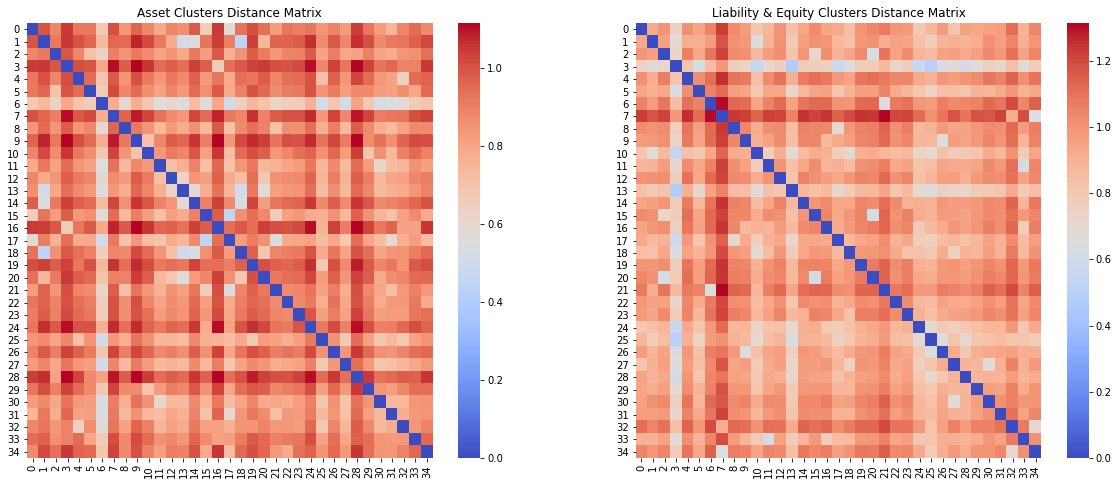

In [19]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
sns.heatmap(distance_matrix(assetCenters), cmap='coolwarm', ax=axes[0])
sns.heatmap(distance_matrix(liabilityCenters), cmap='coolwarm', ax=axes[1])
axes[0].set_title('Asset Clusters Distance Matrix')
axes[1].set_title('Liability & Equity Clusters Distance Matrix')
plt.show()

Clustering works to great effect with the vast majority of cases presented, but there still appears to be issues that persist when trying to divide the current dataset - namely more nuanced differences such as "Total Liabilites and Equity" and "Total Equity". I want to try grouping these and then clustering them again.

As exhbited, repeated clustering on a smaller subset of line items does not break it into expected groups. Rather, we arrive at similar breaks that we saw before when using a smaller KMeans cluster set. Hence, I will pursue the LDA as is, and see the label identificaition that follows.

## Latent Dirichlet Allocation with online variational Bayes algorithm
**A Topic Model for root-word detection from a list of similar strings** 

Our goal here is to determine whether using LDA decomposition is useful in determining label names for clustering classes

* The corpus is a collection of **D** documents, which will be a cluster with corresponding word groupings from KMeans
* A document is a sequence of **N** words, which corresponds to the sequence of characters of each word in the cluster
* There are **K** topics in the corpus, which will be one as we are looking to determine roots

In [20]:
def label_LDA(names, LDA_model):
    assert type(LDA_model).__name__ is 'LatentDirichletAllocation', 'Model restriction, only imposed LDA'
    
    print('Clustered names provided are:\n\n', names, '\n')
    labelNames = []
    
    # vectorize the text (string) data to be used by Latent Dirichlet Allocation algorithm
    text_mdl = TfidfVectorizer()
    vec_text = text_mdl.fit_transform(names)
    
    # feature names extracted from the TfidVectorizer
    feature_names = text_mdl.get_feature_names()
  
    # fit Laten Dirichlet Allocation model 
    mdl = LDA_model
    mdl.fit(vec_text)
    
    print()
    # print out label names determined from LDA
    for topic in mdl.components_:
        message = "Topic determined: "
        message += " ".join([feature_names[i]
                             # select the 5 most important feature names from largest to smallest order
                             for i in topic.argsort()[:-5 - 1:-1]])
        print(color.BOLD, message, color.END)
        labelNames.append(message)
    print()
    
    return labelNames

Continuing this current assesment of topic detection, we extend this to the entire subset of items computed from the clustering algorithm employed to group each of the asset/liability line items grouped before. **(Refer to KMeans Model for details on clustering)**


In [21]:
# creating names for assest line clusters
for i in range(df1.Labels.max()+1):
    print('Label', i)
    cluster_cells = df1[df1.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Securities received as collateral, at fair value (includes $24,592 pledged as collateral)'
 'Pledged as collateral'
 'Securities received as collateral from affiliate'
 'Securities received as collateral, at fair value ($24,265 of which was encumbered)'
 'Securities received as collateral, at fair value (includes $31,554 pledged as collateral)'
 'Securities received as collateral (includes $14,132 pledged as collateral)'
 'Collateral received for securities lending activities'
 'Securities received as collateral, at fair value ($3,960 of which was encumbered)'
 'Securities received as collateral, at fair value (included assets pledged of $1,912)'
 'Securities received as collateral, at fair value ($2,789 of which was encumbered)'
 'Other assets (includes $875 of securities received as collateral at fair value)'
 'Securities received as collateral (all of which was encumbered)'
 'Securities received as collateral'
 'Other assets (includes $2,62

iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: and regulations securities segregated under 


Label 6

Clustered names provided are:

 ['Reverse repurchase agreements' 'Contractual commitments' 'Mutual funds'
 'Equities' 'Stocks, warrants, and options pledged as collateral'
 'Prepaid expenses' 'Certificate of deposit' 'Equity instruments'
 'Asset-backed securities' 'Short-term investments pledged'
 'Unrealized gain on forward commitments'
 'Securities owned ($804,335,072 pledged)'
 'Collateral held under securities loan agreements'
 'Due from Calvert mutual funds'
 'Receivable on derivative contracts, at fair value'
 'Stocks, warrants and options pledged as collateral'
 'Stocks, warrants, and options' 'Total asset'
 'all are pledged to a clearing organiza

iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: at cost value exchange memberships 


Label 9

Clustered names provided are:

 ['Securities purchased under resale agreements (included $16,157 at fair value)'
 'Securities purchased under resale agreements'
 'Securities purchased under resale agreements (included $14,887 at fair value)'
 'Resale agreements'
 'Securities purchased under resale agreements (included $14,320 at fair value)'
 'Securities purchased under resale agreements (included $15,170 at fair value)'
 'Securities purchased under resale agreements (included $12,133 at fair value)'
 'Securities purchased under resale agreements (included $14,133 at fair value)'
 'Securities purchased under resale agreements (included $13,686 at fair value)'
 'Securities purchased under resale agreements (included $167,958 at fair value)'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
itera

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: of and depreciation amortization accumulated 


Label 14

Clustered names provided are:

 ['Office furniture, equipment, and leasehold improvements, at cost, less accumulated depreciation and amortization of $55,642'
 'Furniture, equipment and leasehold improvements, at cost (less accumulated depreciation and amortization of $4,766,219)'
 'Furniture and office equipment, at cost, less accumulated depreciation of $415,720'
 'Furniture, office equipment and leasehold improvements, at cost, less accumulated depreciation and amortization of $85, 141'
 'Property, equipment and leasehold improvements, at cost (less accumulated depreciation and amortization of $207,276)'
 'PROPERTY AND E

iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: brokers clearing and organizations dealers 


Label 17

Clustered names provided are:

 ['Securities owned, at fair value (includes $16,590,044 pledged as collateral)'
 '(including securities owned, pledged to counterparties of $ 7,467,081)'
 'Securities owned, at fair value (Note 5)'
 'Securities owned - at fair value ($62,006 pledged as collateral)'
 'Securities owned - at fair value (including securities owned, pledged to counterparties of $16,480,936)'
 'Securities owned, at fair value (includes $2,403,570 pledged as collateral)'
 'Securities owned'
 'Securities owned - at fair value (including securities owned, pledged to counterparties of $55,135,765)'
 '(including securities owned, pledged to counterpa

iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: of fixed assets net depreciation 


Label 21

Clustered names provided are:

 ['Securities owned - at market value (including securities pledged of $8)'
 'Securities owned - at market value (including securities pledged of $3)'
 'Money market instruments'
 'Financial instruments owned, at market value (cost $55,563,490)'
 'Securities owned, at market value'
 'Financial instruments, at market value'
 'Trading inventory, at market value, pledged (Note 4)'
 'Trading inventory, at market value (Note 4)'
 'Trading securities owned-at market value (Notes 2 and 4)'
 'Trading inventory, at market value'
 'Trading securities owned-al market value (Notes 2 and 4)'
 'Securities owned - at market value (including securities pledged of $5)'
 'Securit


 Topic determined: government and securities agency obligations 


Label 27

Clustered names provided are:

 ['Investment in limited partnership'
 'In thousands of dollars, except share information'
 'Investment in affiliate' 'Change in deposits'
 'in thousands of dollars, except share information'
 'Change in prepaid expenses' '$134 in 2002)'
 'Change in payable to clearing broker' 'Change in due to affilate'
 'Change in receivable from clearing broker'
 'Investment in exchange membership - at fair value'
 'Investment in Morgan Stanley Smith Barney Holdings LLC (including Preferred Securities of $2,153)'
 'Change in accounts payable'
 'Investment in Morgan Stanley Smith Barney Holdings LLC (including Preferred Securities of $2,000)'
 'Change in securities owned' 'Interest-bearing deposit in bank'
 'Securities deposited in special reserve bank account for the exclusive benefit of customers'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
itera

iteration: 10 of max_iter: 10

 Topic determined: deposits with clearing and organization 


Label 34

Clustered names provided are:

 ['Financial instruments owned, at fair value (approximately $61,278 were pledged to various parties)'
 'Securities received as collateral, at fair value (approximately $5,412 were pledged to various parties)'
 'Trading assets ($11,682,085 were pledged to various parties)'
 'Securities owned, at fair value ($84,891 were pledged to various parties)'
 'Trading assets ($375,841 were pledged to various parties)'
 'Securities received as collateral, at fair value (approximately $14,956 were pledged to various parties)'
 'various parties)'
 'Securities owned (100% was pledged to various parties)'
 'Trading assets ($14,615,973 were pledged to various parties)'
 'Trading assets ($6,241,422 were pledged to various parties)'
 'Securities owned, at fair value (all pledged to various parties)'
 'Financial instruments owned ($14,422,951 were pledged to various partie

In [22]:
df1.to_csv('LDA_asset.csv', index=False)

In [23]:
# creating names for liability line clusters
for i in range(df2.Labels.max()+1):
    print('Label', i)
    cluster_cells = df2[df2.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Other liabilities, of which $621 reported at fair value'
 'Other liabilities, of which $510 is reported at fair value'
 'and is from consolidated VIEs'
 'Other liabilities, of which $336 reported at fair value.'
 'Other liabilities, of which $997 reported at fair value and $1 is from consolidated VIEs'
 'Subordinated and other long-term borrowings, of which $476 is reported at fair value and is from consolidated VIEs'
 'Other liabilities, of which $339 reported at fair value'
 'Other liabilities, of which $562 reported at fair value and $1 is from consolidated VIEs'
 'Other liabilities, of which $1,155 reported at fair value'
 'Securities loaned, of which $87 is reported at fair value'
 'Subordinated and other long-term borrowings, of which $93 is reported at fair value and is from consolidated VIEs'
 'Subordinated and other long-term borrowings, of which $2,925 is reported at fair value and from consolidated VIEs'
 'Other liabilities, of whic

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: interest payable dividends and accrued 


Label 6

Clustered names provided are:

 ['Financial instruments sold, not yet purchased'
 'Financial instruments sold, but not yet purchased, at fair value'
 'Financial liabilities, at fair value'
 'Financial instruments sold, not yet purchased, at fair value'
 'Financial instruments sold, but not yet purchased at fair value'
 'Financial instruments sold, but not yet purchased, at fair value (including $1,687 in consolidated VIEs)'
 'Financial instruments sold but not yet purchased'
 'Financial instruments sold, but not yet purchased, M fair value'
 'Financial instruments sold, but not yet purchased, at fair value:'
 'Financial instrument

 ['Foreign government securities'
 'Accrued employee compensation and benefits' 'Compensation and benefits'
 'U.S. government and federal agency securities'
 'Accrued compensation and related benefits'
 'U.S. government and agencies' 'Legal and regulatory reserves'
 'Compensation payable' 'Legal reserves and legal expense payable'
 'Employee compensation and benefits payable'
 'U.S. government and government agency securities'
 'Accrued compensation and benefits'
 'Legal reserves and legal expenses payable'
 'U.S. Treasury and federal agency securities'
 'U.S. Government and agency obligations' 'Stocks, warrants, and options'
 'Other sovereign government obligations'
 'Non-U.S. government and government agency securities'
 'Stocks, warrants and options' 'U.S. Treasury and government agencies'
 'Accrued compensation' 'Governments and agencies'
 'State and municipal bond obligations'
 'U.S. government and federal agency'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iterat

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: shares 000 common value authorized 


Label 21

Clustered names provided are:

 ['Securities sold, but not yet purchased'
 'Trading securities sold, not yet purchased, at fair value'
 'Securities sold, not yet purchased, at market value (Note 4)'
 'Securities sold, but not yet purchased, at market value'
 'Trading securities sold, but not yet purchased - at market value (Notes 2 and 4)'
 'Securities sold, not yet purchased at fair value'
 'Securities sold, but not yet purchased, at market'
 'Securities sold, not yet purchased, at market value'
 'Securities sold. not yet purchased, at fair value'
 'Trading securities sold. but not yet purchased-at market value (Notes 2 and 4)'
 'Securities sold, not yet purchased, at fair value'
 'Securities sold, not yet purchased, at market value, obligation to return collateral (Note 4)'
 'Securities sold, but not y

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: other liabilities accrued expenses and 


Label 28

Clustered names provided are:

 ['Income taxes payable (Notes 2 and 14)' 'Securities (Notes 2 and 3)'
 'Taxes Payable' 'Undistributed income' 'Notes payable'
 'Notes payable to SSBH' 'Taxes payable'
 'Current income taxes payable to Parent' 'Income taxes payable'
 'Income taxes payable (Notes 2 and 17)' 'Deferred taxes liability'
 'Notes payable to CGMHI' 'Income taxes payable (Notes 2 and 16)'
 'Senior notes'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: payable taxes notes income and 


Label 29

Clustered names provided are:

 ['Deriv

In [24]:
df2.to_csv('LDA_liability.csv', index=False)